In [1]:
import pandas as pd
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import pdb
import scipy
from scipy.optimize import minimize, fmin
from scipy.stats import multivariate_normal
from tqdm.notebook import tqdm
import matplotlib
from mpl_toolkits import mplot3d

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['arial']
def makeAxesPretty(ax):
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [2]:
""" 
Obtaining data from a given expt
"""
csv_test = pd.read_csv('subjectDataForPlots/allTrials_noBias.csv')
csv_data = pd.read_csv('subjectDataForPlots/noContextData/5ea1f4fa7a70090fd0715b34_categorization_task_2021-03-01_18h06.17.396.csv');
                       

In [3]:
n_tones = 3
n_trials = csv_data.shape[0]-47

"""
Get tones, tonetypes and values of keys pressed
"""
test_columns = list(csv_test.columns)
test_tones_name = test_columns.index('Name')
test_tones_col_idx = test_columns.index('Tones')
test_tones_kind = test_columns.index('Tonekind')
df_names = (csv_test.iloc[0:600,test_tones_name]).values
df_tones = (csv_test.iloc[0:600,test_tones_col_idx]).values
df_tonekind = (csv_test.iloc[0:600,test_tones_kind]).values

tones_array_orig = np.zeros((n_trials,n_tones))
tonekind_array_orig = np.zeros((n_trials,n_tones))
tones_array_idxs_keep = []

for i_wav in range(603):
    if isinstance(csv_data['Name'][i_wav+46],str):
        tones_array_orig[i_wav,:] = np.array(df_tones[np.where(csv_data['Name'][i_wav+46]
                                                               ==df_names)[0]][0][1:-1].split(',')).astype(float)
        tonekind_array_orig[i_wav,:] = np.array(df_tonekind[np.where(csv_data['Name'][i_wav+46]
                                                                     ==df_names)[0]][0][1:-1].split(',')).astype(float)
        tones_array_idxs_keep += [i_wav]
        
#pdb.set_trace()
        
df_tones = np.copy(tones_array_orig[tones_array_idxs_keep,:])
df_tonekind = np.copy(tonekind_array_orig[tones_array_idxs_keep,:])
df_corrans = np.copy(csv_data['corrAns'][46:csv_data.shape[0]])[tones_array_idxs_keep]
df_keys = np.copy(csv_data['test_resp.keys'][46:csv_data.shape[0]])[tones_array_idxs_keep]


In [4]:
df_tones.shape, df_tonekind.shape

((600, 3), (600, 3))

In [5]:
"""
Find no response cases in the expt
"""
no_response = np.intersect1d(np.where(df_keys!='h')[0],np.where(df_keys!='l')[0])
print("Did not respond to: ",no_response)

"""
Convert keys ['l','h'] to [0,1] and calculate accuracies
"""
corrans_num_orig = np.zeros_like(df_corrans)
corrans_num_orig[df_corrans == 'h'] = 1

keys_num_orig = np.zeros_like(df_keys)
keys_num_orig[df_keys == 'h'] = 1

corrans_num = corrans_num_orig[:600]
keys_num = keys_num_orig[:600]
tones_array = df_tones[:600]
tonekind_array = df_tonekind[:600]

print("Got correct: ", np.sum(keys_num==corrans_num)/len(tones_array))
print("Got high correct: ", np.sum((keys_num)*(corrans_num))/np.sum(corrans_num))
print("Got low correct: ", np.sum((1-keys_num)*(1-corrans_num))/np.sum(1-corrans_num))

"""
Defining expt variable
"""

trial_tones = np.repeat(tones_array,1,axis = 0)
trial_tonekind = np.repeat(tonekind_array,1,axis=0)
trial_behaviour = np.reshape(keys_num,np.prod(keys_num.shape))
#this has been changed to check how values change with observer responses

expt_tones = np.arange(90,3000,1) #array of possible true tones
log_freq_seq_array = np.arange(0.6,4.7,0.1)
log_freq_percept = np.arange(0.6,4.7,0.1) # array of possible perceptual tones

idxs_with_response = np.delete(np.arange(len(trial_tones)),no_response)
trial_tones = trial_tones[idxs_with_response,:]
trial_tonekind = trial_tonekind[idxs_with_response,:]
trial_behaviour = trial_behaviour[idxs_with_response]
trial_corrans = corrans_num[idxs_with_response]


Did not respond to:  [150 151 152 153 154 155 156 185 191 195 230 238 266 346 568 585]
Got correct:  0.8033333333333333
Got high correct:  0.7940199335548173
Got low correct:  0.8127090301003345


In [6]:
def gaussian(x, mean, sigma):
    return np.exp(-(x-mean)**2/(2*sigma**2))

def Tones3dgrid(latentTones, sigma):    
    
    input_array_0 = np.expand_dims(gaussian(log_freq_percept, latentTones[0], sigma), axis = 1)
    input_array_1 = np.expand_dims(gaussian(log_freq_percept, latentTones[1], sigma), axis = 1)
    input_array_2 = np.expand_dims(gaussian(log_freq_percept, latentTones[2], sigma), axis = 1)
    s0 = 1/np.sum(input_array_0); 
    s1 = 1/np.sum(input_array_1); 
    s2 = 1/np.sum(input_array_2);
    input_array_0 *= s0; 
    input_array_1 *= s1; 
    input_array_2 *= s2; 
    
    input_array_mat = np.expand_dims(input_array_0@input_array_1.T,axis=2)@(input_array_2.T) #p(T1,T2..|H)   
                                     
    return input_array_mat


def posterior_array(freq_input, n_tones, p_back, log_prior):
    """
    Arguments: 
    freq_input - range of all possible frequencies (percepts?)
    p_back - prob of background
    p_low - prob of low condition
    log_prior - list of prior parameters
    """
    
    log_prior_low_mean = log_prior[0]; log_prior_low_sigma = log_prior[2];
    log_prior_high_mean = log_prior[1]; log_prior_high_sigma = log_prior[2];
    likelihood_onetone_low = gaussian(x=freq_input, mean=log_prior_low_mean, sigma=log_prior_low_sigma)
    likelihood_onetone_high = gaussian(x=freq_input, mean=log_prior_high_mean, sigma=log_prior_high_sigma)
    likelihood_onetone_mixed_high = p_back*(1/len(freq_input)) + (1-p_back)*likelihood_onetone_high
    #mixture model with p(T|B) = 1/no. of possible freqs
    likelihood_onetone_mixed_high /= likelihood_onetone_mixed_high.sum() #normalizing
    likelihood_onetone_mixed_high = np.expand_dims(likelihood_onetone_mixed_high, axis = 1)
    likelihood_onetone_mixed_low = p_back*(1/len(freq_input)) + (1-p_back)*likelihood_onetone_low
    #mixture model with p(T|B) = 1/no. of possible freqs
    likelihood_onetone_mixed_low /= likelihood_onetone_mixed_low.sum() #normalizing
    likelihood_onetone_mixed_low = np.expand_dims(likelihood_onetone_mixed_low, axis = 1)
            
    if n_tones == 3:
        likelihood_alltones_low = (np.expand_dims(likelihood_onetone_mixed_low@np.transpose
                                                 (likelihood_onetone_mixed_low),axis=2)
                                   @np.transpose(likelihood_onetone_mixed_low))
        #p(T1,T2..|L) 
        likelihood_alltones_high = (np.expand_dims(likelihood_onetone_mixed_high@np.transpose
                                                 (likelihood_onetone_mixed_high),axis=2)
                                    @np.transpose(likelihood_onetone_mixed_high))
        #p(T1,T2..|H) 
    elif n_tones == 1:
        likelihood_alltones_low = likelihood_onetone_mixed_low
        likelihood_alltones_high = likelihood_onetone_mixed_high

    return [likelihood_onetone_mixed_high, likelihood_onetone_mixed_low, 
            likelihood_alltones_high, likelihood_alltones_low]


In [7]:
"""
Fitting using mle
"""
def MLE(params):
    log_prior_low_mean, log_prior_high_mean, log_prior_sigma, sigma_sensory, prob_back, prob_low = \
    params[0], params[1], params[2], params[3], params[4], params[5] # inputs are guesses at our parameters  
    
    [_,_,LikelihoodLatentTonegivenHigh,
     LikelihoodLatentTonegivenLow] = posterior_array(log_freq_seq_array, n_tones=len(trial_tones[0]), 
                                                     p_back=prob_back, 
                                                     log_prior=[log_prior_low_mean, 
                                                                log_prior_high_mean,
                                                                log_prior_sigma])

    LikelihoodPerceptgivenHigh = np.zeros((len(log_freq_percept),len(log_freq_percept),len(log_freq_percept)))
    LikelihoodPerceptgivenLow = np.zeros((len(log_freq_percept),len(log_freq_percept),len(log_freq_percept)))
    
    for itrue1 in range(len(log_freq_seq_array)):
        for itrue2 in range(len(log_freq_seq_array)):            
            for itrue3 in range(len(log_freq_seq_array)):
                probPerceptgivenLatentTones = Tones3dgrid([log_freq_seq_array[itrue1],\
                                                           log_freq_seq_array[itrue2],\
                                                           log_freq_seq_array[itrue3]],sigma=sigma_sensory)                                                           
                LikelihoodPerceptgivenHigh \
                += probPerceptgivenLatentTones * LikelihoodLatentTonegivenHigh[itrue1,itrue2,itrue3]
                LikelihoodPerceptgivenLow \
                += probPerceptgivenLatentTones * LikelihoodLatentTonegivenLow[itrue1,itrue2,itrue3]
    probHighgivenPercept = LikelihoodPerceptgivenHigh*(1-prob_low)/\
    (LikelihoodPerceptgivenHigh*(1-prob_low) + LikelihoodPerceptgivenLow*(prob_low))
        
    neg_ll = 0; 
    probability_high = np.zeros((len(trial_tones),1))
    for i_trial in range(len(trial_tones)):
        input_array_mat = Tones3dgrid(np.array([np.log10(trial_tones[i_trial][0]),
                                               np.log10(trial_tones[i_trial][1]),
                                               np.log10(trial_tones[i_trial][2])]),sigma=sigma_sensory)
        probability_high0 = np.sum(np.multiply(probHighgivenPercept>0.5,input_array_mat))
        probability_high[i_trial] = np.sum(np.multiply(probHighgivenPercept>0.5,input_array_mat))
            
        if trial_behaviour[i_trial]:
            if np.isnan(np.log(probability_high0 + 0.0000001)) \
            or np.isinf(np.log(probability_high0 + 0.0000001)) \
            or np.isnan(np.log(1-probability_high0 + 0.0000001)) \
            or np.isinf(np.log(1-probability_high0 + 0.0000001)):
                pdb.set_trace()
            neg_ll += -np.log(probability_high0 + 0.0000001) # if high dist is chosen by observer
        else:
            neg_ll += -np.log(1 - probability_high0 + 0.0000001) # if low dist is chosen by observer
    return(neg_ll, probability_high)


In [8]:
"""
Generative process of experimental task
"""
def task(freq_seq, lm, hm, s, n_trials = 10, n_tones = 3, p_low = 0.5, p_back = 0.3):
    expt_log_freq_seq_array = np.arange(np.log10(freq_seq[0]), np.log10(freq_seq[-1]), np.log10(1003/1000)*40)
    print(expt_log_freq_seq_array)
    log_freq_seq_mid = np.median(expt_log_freq_seq_array)
    log_freq_low = [lm,s]#[log_freq_seq_mid - 0.15,0.1]  #low freq condition is gaussian 
    log_freq_high = [hm,s]#[log_freq_seq_mid + 0.15,0.1] #high freq condition is gaussian
    trial_tones = []
    dist_chosen = []
    kind_of_tones = []

    for trial in range(n_trials):
        signal_rand = np.random.random()
        low_dist = signal_rand < p_low #choosing true tone from either low or high condition
        tones = []
        tone_kind = []
        for n_tone in range(n_tones):
            signal_back = np.random.random()
            background = signal_back < p_back #choosing background or true tone
            if background:
                nearest_log_tone = np.random.choice(expt_log_freq_seq_array)
                #background freq is chosen from a uniform distribution
                tone_kind.append(0)
            else: 
                if low_dist:
                    tone = min(max(np.random.randn()*log_freq_low[1] + log_freq_low[0],
                                   expt_log_freq_seq_array[0]),expt_log_freq_seq_array[-1])                    
                    tone_kind.append(1)
                else:
                    tone = min(max(np.random.randn()*log_freq_high[1] + log_freq_high[0],
                                   expt_log_freq_seq_array[0]),expt_log_freq_seq_array[-1])
                    tone_kind.append(2)
                nearest_log_tone = expt_log_freq_seq_array[np.argmin(np.abs(expt_log_freq_seq_array - tone))]
            nearest_tone = freq_seq[np.argmin(np.abs(freq_seq - 10**nearest_log_tone))]        
            tones.append(nearest_tone)
        trial_tones.append(tones)
        dist_chosen.append(low_dist)
        kind_of_tones.append(tone_kind)
    return trial_tones, dist_chosen, kind_of_tones, log_freq_low, log_freq_high


In [9]:
"""
Simulating participant behaviour
"""
def generate_behaviour(trial_tones, reps, n_tones, prob_back, prob_low, log_prior_params, sigma_sensory):  

    all_trial_tones = np.empty((len(trial_tones)*reps,n_tones))
    all_trial_behaviour = np.empty((len(trial_tones)*reps,1))
    prob_trial_behaviour = np.empty((len(trial_tones),1))
    probability_sim_high = np.zeros((len(trial_tones),1))

    [_,_,LikelihoodLatentTonegivenHigh,LikelihoodLatentTonegivenLow] = \
    posterior_array(log_freq_seq_array, n_tones=len(trial_tones[0]), 
                    p_back=prob_back, log_prior=log_prior_params)

    LikelihoodPerceptgivenHigh = np.zeros((len(log_freq_percept),len(log_freq_percept),len(log_freq_percept)))
    LikelihoodPerceptgivenLow = np.zeros((len(log_freq_percept),len(log_freq_percept),len(log_freq_percept)))

    for itrue1 in range(len(log_freq_percept)):
        for itrue2 in range(len(log_freq_percept)):
            for itrue3 in range(len(log_freq_percept)):
                probPerceptgivenLatentTones = Tones3dgrid([log_freq_percept[itrue1],
                                                           log_freq_percept[itrue2],
                                                           log_freq_percept[itrue3]],sigma=sigma_sensory)
                LikelihoodPerceptgivenHigh \
                += probPerceptgivenLatentTones * LikelihoodLatentTonegivenHigh[itrue1,itrue2,itrue3]
                LikelihoodPerceptgivenLow \
                += probPerceptgivenLatentTones * LikelihoodLatentTonegivenLow[itrue1,itrue2,itrue3]
    probHighgivenPercept = LikelihoodPerceptgivenHigh*(1-prob_low)/\
    (LikelihoodPerceptgivenHigh*(1-prob_low) + LikelihoodPerceptgivenLow*prob_low)

    for i_stim in range(len(trial_tones)):
        input_array = np.random.normal(loc=np.log10(trial_tones[i_stim]),scale=sigma_sensory,
                                       size=(reps,1,n_tones))
        #pick tones from the gaussian with mean as log(true_tone) and sensory sigma 0.1    
        for i_tperc in range(reps):
            perc_tone_idxs = np.zeros((n_tones,1),dtype=int)
            for i in range(n_tones):
                perc_tone_idxs[i] = np.argmin(np.abs(log_freq_percept-input_array[i_tperc][0][i]))
                # find relevant adjacent freq percepts   
            posterior_perc_tone = probHighgivenPercept[perc_tone_idxs[0],perc_tone_idxs[1],perc_tone_idxs[2]]
            # trial_behaviour = (np.random.random_sample() < np.squeeze(posterior_perc_tone)).astype(int)
            # this encodes decision noise
            trial_behaviour = np.squeeze(posterior_perc_tone) > 0.5
            # this makes the same choice for one tone percept every time that tone is perceived   
            all_trial_behaviour[i_stim*reps+i_tperc,:] = trial_behaviour
        all_trial_tones[i_stim*reps:(i_stim+1)*reps,:] = trial_tones[i_stim]    
        prob_trial_behaviour[i_stim] = np.mean(all_trial_behaviour[i_stim*reps:(i_stim+1)*reps])

        gaussian_array_mat = Tones3dgrid(np.array([np.log10(trial_tones[i_stim][0]),
                                                   np.log10(trial_tones[i_stim][1]),
                                                   np.log10(trial_tones[i_stim][2])]),sigma=sigma_sensory)         
        probability_sim_high[i_stim] = np.sum(np.multiply(probHighgivenPercept>0.5, gaussian_array_mat))

    return all_trial_tones, probability_sim_high

def generate_behaviourRandomChoice(params, trial_tones):
    sigma_sensory, prob_low = params[0], params[1] # inputs are guesses at our parameters  
    
    prob_trial_behaviour = np.zeros((len(trial_tones),1))
    for i_trial in range(len(trial_tones)):
        gaussian_array_mat = Tones3dgrid(np.array([np.log10(trial_tones[i_trial][0]),
                                                   np.log10(trial_tones[i_trial][1]),
                                                   np.log10(trial_tones[i_trial][2])]),sigma=sigma_sensory)
        prob_trial_behaviour[i_trial] = np.sum(np.multiply((1-prob_low), gaussian_array_mat))
            
    return(prob_trial_behaviour)


In [10]:
def plottingInfluenceFn(tones, behaviour):
    unique_tones = np.unique(tones)

    tone1_prob_behaviour = np.zeros((len(unique_tones),1))
    tone2_prob_behaviour = np.zeros((len(unique_tones),1))
    tone3_prob_behaviour = np.zeros((len(unique_tones),1))

    for i_tone in range(len(unique_tones)):
        tone1_prob_behaviour[i_tone] = np.mean(behaviour[tones[:,0]==unique_tones[i_tone]])
        tone2_prob_behaviour[i_tone] = np.mean(behaviour[tones[:,1]==unique_tones[i_tone]])
        tone3_prob_behaviour[i_tone] = np.mean(behaviour[tones[:,2]==unique_tones[i_tone]])
    behaviour = np.concatenate((tone1_prob_behaviour,tone2_prob_behaviour,tone3_prob_behaviour),axis=1)
    return unique_tones, behaviour

unique_tones_played, subjectBehaviour = plottingInfluenceFn(trial_tones, trial_behaviour) 


In [11]:
def plottingSignalTonesBasedCurves(tones, behaviour, toneKind):
    
    toneKind = np.array(toneKind)
    expt_log_freq = np.arange(np.log10(90), np.log10(3000), np.log10(1003/1000)*40)

    idx = np.arange(0,len(tones))
    noDistractor_idx = idx[np.sum(np.array(toneKind)==0, axis=1)==0]
    oneDistractor_idx = idx[np.sum(np.array(toneKind)==0, axis=1)==1]
    twoDistractor_idx = idx[np.sum(np.array(toneKind)==0, axis=1)==2]
    threeDistractor_idx = idx[np.sum(np.array(toneKind)==0, axis=1)==3]
    
    noDistractorTrials = np.log10(tones[noDistractor_idx,:])
    oneDistractorTrials = np.log10(tones[oneDistractor_idx,:])
    twoDistractorTrials = np.log10(tones[twoDistractor_idx,:])
    threeDistractorTrials = np.log10(tones[threeDistractor_idx,:])
    
    noDistractorBehavior = behaviour[noDistractor_idx]
    oneDistractorBehavior = behaviour[oneDistractor_idx]
    twoDistractorBehavior = behaviour[twoDistractor_idx]
    threeDistractorBehavior = behaviour[threeDistractor_idx]
    
    meanTone_raw = np.empty(shape=(len(tones),))
    meanTone = np.empty_like(meanTone_raw)
    for trialIdx in idx:
        meanTone_raw[trialIdx] = np.mean(np.log10(tones[trialIdx][toneKind[trialIdx]==0]))
        meanTone[trialIdx] = expt_log_freq[np.argmin(np.abs(expt_log_freq-meanTone_raw[trialIdx]))]
           
    noDistractor_meanTone = meanTone[noDistractor_idx]
    oneDistractor_meanTone = meanTone[oneDistractor_idx]
    twoDistractor_meanTone = meanTone[twoDistractor_idx]
    threeDistractor_meanTone = meanTone[threeDistractor_idx]
    
    noDistractor_unique_meanTone = np.unique(noDistractor_meanTone)
    oneDistractor_unique_meanTone = np.unique(oneDistractor_meanTone)
    twoDistractor_unique_meanTone = np.unique(twoDistractor_meanTone)
    threeDistractor_unique_meanTone = np.unique(threeDistractor_meanTone)
    
    noDistractor_prob_behaviour = np.zeros((len(noDistractor_unique_meanTone),2))
    oneDistractor_prob_behaviour = np.zeros((len(oneDistractor_unique_meanTone),2))
    twoDistractor_prob_behaviour = np.zeros((len(twoDistractor_unique_meanTone),2))
    threeDistractor_prob_behaviour = np.zeros((len(threeDistractor_unique_meanTone),2))

    for i_tone in range(len(noDistractor_unique_meanTone)):
        noDistractor_prob_behaviour[i_tone,0] = np.mean(noDistractorBehavior[noDistractor_meanTone==noDistractor_unique_meanTone[i_tone]])
        noDistractor_prob_behaviour[i_tone,1] = np.std(noDistractorBehavior[noDistractor_meanTone==noDistractor_unique_meanTone[i_tone]])/np.sqrt(np.sum(noDistractor_meanTone==noDistractor_unique_meanTone[i_tone]))
    for i_tone in range(len(oneDistractor_unique_meanTone)):
        oneDistractor_prob_behaviour[i_tone,0] = np.mean(oneDistractorBehavior[oneDistractor_meanTone==oneDistractor_unique_meanTone[i_tone]])
        oneDistractor_prob_behaviour[i_tone,1] = np.std(oneDistractorBehavior[oneDistractor_meanTone==oneDistractor_unique_meanTone[i_tone]])/np.sqrt(np.sum(oneDistractor_meanTone==oneDistractor_unique_meanTone[i_tone]))
    for i_tone in range(len(twoDistractor_unique_meanTone)):
        twoDistractor_prob_behaviour[i_tone,0] = np.mean(twoDistractorBehavior[twoDistractor_meanTone==twoDistractor_unique_meanTone[i_tone]])
        twoDistractor_prob_behaviour[i_tone,1] = np.std(twoDistractorBehavior[twoDistractor_meanTone==twoDistractor_unique_meanTone[i_tone]])/np.sqrt(np.sum(twoDistractor_meanTone==twoDistractor_unique_meanTone[i_tone]))
    for i_tone in range(len(threeDistractor_unique_meanTone)):
        threeDistractor_prob_behaviour[i_tone,0] = np.mean(threeDistractorBehavior[threeDistractor_meanTone==threeDistractor_unique_meanTone[i_tone]])
        threeDistractor_prob_behaviour[i_tone,1] = np.std(threeDistractorBehavior[threeDistractor_meanTone==threeDistractor_unique_meanTone[i_tone]])/np.sqrt(np.sum(threeDistractor_meanTone==threeDistractor_unique_meanTone[i_tone]))
    
    return [noDistractor_unique_meanTone, oneDistractor_unique_meanTone, twoDistractor_unique_meanTone, threeDistractor_unique_meanTone,
            noDistractor_prob_behaviour, oneDistractor_prob_behaviour, twoDistractor_prob_behaviour, threeDistractor_prob_behaviour]

#[noDistractor_meanTone, oneDistractor_meanTone,twoDistractor_meanTone,
#noDistractorBehavior, oneDistractorBehavior, twoDistractorBehavior] = plottingSignalTonesBasedCurves(trial_tones, 
#                                                                                                     trial_behaviour,
#                                                                                                     trial_tonekind)


0.04122600431346968


/Users/janakisheth/anaconda3/envs/uncertaintyProj/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/janakisheth/anaconda3/envs/uncertaintyProj/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in long_scalars
  ret = ret / rcount


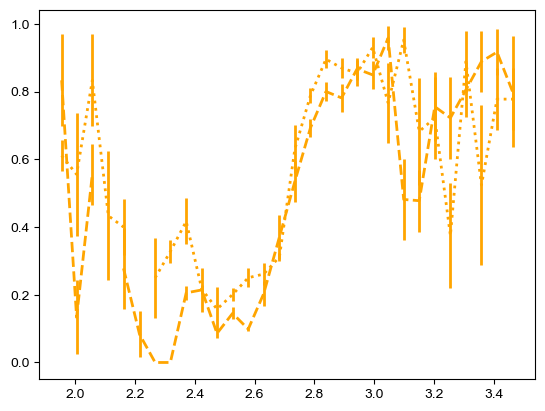

In [12]:

def localVsGlobalEffect(tones,corrAns,behaviour):
    
    """
    Prev trial is overrepresented
    """
    trialsIdxs = np.arange(len(corrAns)-1)
    lowCategoryIdx = trialsIdxs[corrAns[:-1]==0]
    trialsSucceedingLowCategory = tones[lowCategoryIdx+1,:]
    behaviourSucceedingLowCategory = behaviour[lowCategoryIdx+1]
    corransSucceedingLowCategory = corrAns[lowCategoryIdx+1]

    [unique_tonesPlayed, 
    subjectBehaviourPrevTrialLowCategory] = plottingInfluenceFn(trialsSucceedingLowCategory,
                                                               behaviourSucceedingLowCategory)
    
    """
    Prev trial is underrepresented
    """
    highCategoryIdx = trialsIdxs[corrAns[:-1]==1]
    trialsSucceedingHighCategory = tones[highCategoryIdx+1,:]
    behaviourSucceedingHighCategory = behaviour[highCategoryIdx+1]
    corransSucceedingHighCategory = corrAns[highCategoryIdx+1]
    
    [unique_tonesPlayed, 
    subjectBehaviourPrevTrialHighCategory] = plottingInfluenceFn(trialsSucceedingHighCategory,
                                                                 behaviourSucceedingHighCategory)
    return unique_tonesPlayed, subjectBehaviourPrevTrialLowCategory, subjectBehaviourPrevTrialHighCategory


"""
Value of constraint to restrict the range of parameter fits for short term context
"""

[unique_tones, meanBehaviourAfterLowTrial, 
meanBehaviourAfterHighTrial] = localVsGlobalEffect(tones=trial_tones, 
                                                    behaviour=trial_behaviour, 
                                                    corrAns=trial_corrans)
plt.errorbar(np.log10(unique_tones), np.mean(meanBehaviourAfterLowTrial,axis=1),
             yerr=np.std(meanBehaviourAfterLowTrial,axis=1)/np.sqrt(3), 
             color='orange',linestyle='--',linewidth=2)
plt.errorbar(np.log10(unique_tones), np.mean(meanBehaviourAfterHighTrial,axis=1),
             yerr=np.std(meanBehaviourAfterHighTrial,axis=1)/np.sqrt(3), 
             color='orange',linestyle='dotted',linewidth=2)

constraint = np.nanmean(meanBehaviourAfterLowTrial,axis=1) - np.nanmean(meanBehaviourAfterHighTrial,axis=1)

print(np.abs(np.mean(constraint)/2))


/Users/janakisheth/anaconda3/envs/uncertaintyProj/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[1.95424251 2.00627983 2.05831715 2.11035447 2.16239179 2.21442911
 2.26646643 2.31850376 2.37054108 2.4225784  2.47461572 2.52665304
 2.57869036 2.63072768 2.682765   2.73480232 2.78683964 2.83887696
 2.89091428 2.9429516  2.99498893 3.04702625 3.09906357 3.15110089
 3.20313821 3.25517553 3.30721285 3.35925017 3.41128749 3.46332481]


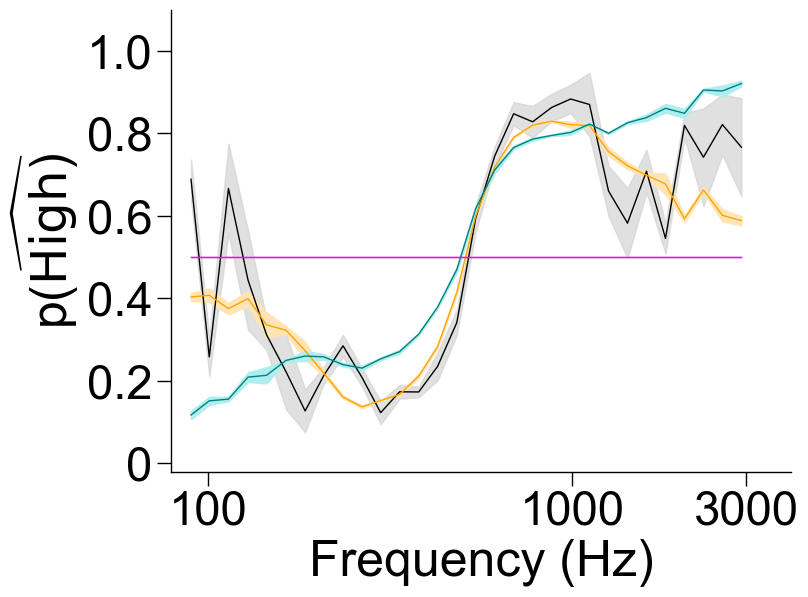

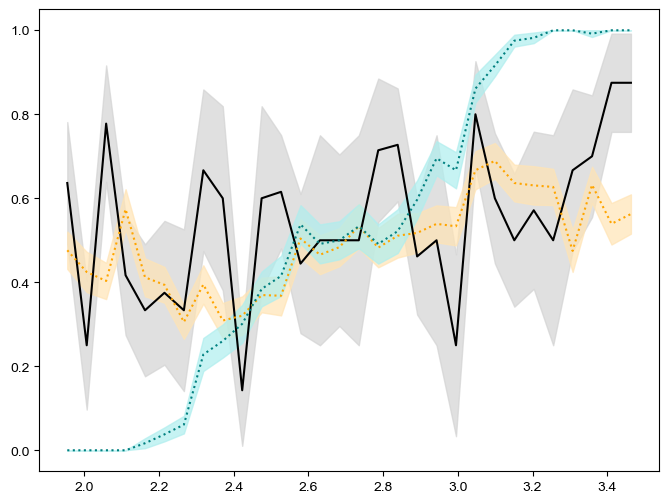

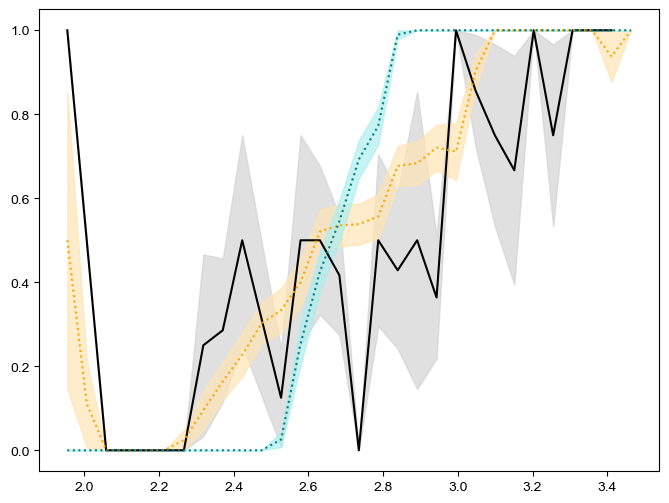

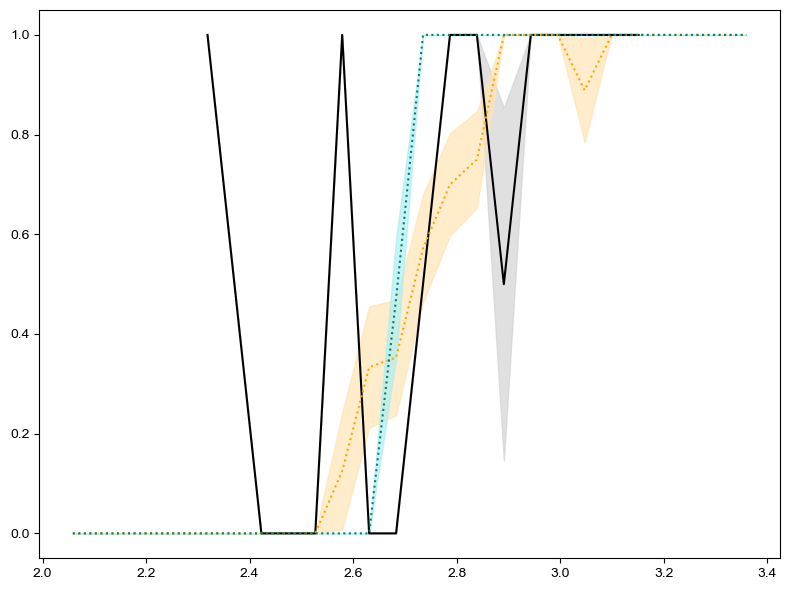

In [13]:
"""
Fitting the different models to the data
Note: the parameters used here are from the excel file present in the subjectData folder. 
"""

fig, ax = plt.subplots(1,1,figsize=(8,6))
#fig1, ax1 = plt.subplots(1,1,figsize=(8,6))
fig2, ax2 = plt.subplots(1,1,figsize=(8,6))
fig3, ax3 = plt.subplots(1,1,figsize=(8,6))
fig4, ax4 = plt.subplots(1,1,figsize=(8,6))

unique_tones_played, subjectBehaviour = plottingInfluenceFn(trial_tones, trial_behaviour) 

[noDistractor_meanTone, oneDistractor_meanTone,twoDistractor_meanTone, 
 threeDistractor_meanTone, noDistractorBehavior, oneDistractorBehavior, 
 twoDistractorBehavior, threeDistractorBehavior] = plottingSignalTonesBasedCurves(trial_tones, 
                                                                                  trial_behaviour,
                                                                                  trial_tonekind)

ax.plot(np.log10(unique_tones_played), np.mean(subjectBehaviour,axis=1),color='k',linewidth=1)
ax.fill_between(np.log10(unique_tones_played), 
                 y1 = np.mean(subjectBehaviour,axis=1) - np.std(subjectBehaviour,axis=1)/np.sqrt(3),
                 y2 = np.mean(subjectBehaviour,axis=1) + np.std(subjectBehaviour,axis=1)/np.sqrt(3),
                 color='lightgray',alpha=0.7)

#ax1.plot(noDistractor_meanTone, noDistractorBehavior[:,0],'k')
#ax1.fill_between(noDistractor_meanTone,
#                 y1 = noDistractorBehavior[:,0] - noDistractorBehavior[:,1],
#                 y2 = noDistractorBehavior[:,0] + noDistractorBehavior[:,1],
#                 color='lightgray',alpha=0.7)
ax2.plot(oneDistractor_meanTone, oneDistractorBehavior[:,0],'k')
ax2.fill_between(oneDistractor_meanTone, 
                 y1 = oneDistractorBehavior[:,0] - oneDistractorBehavior[:,1],
                 y2 = oneDistractorBehavior[:,0] + oneDistractorBehavior[:,1],
                 color='lightgray',alpha=0.7)
ax3.plot(twoDistractor_meanTone, twoDistractorBehavior[:,0],'k')
ax3.fill_between(twoDistractor_meanTone, 
                 y1 = twoDistractorBehavior[:,0] - twoDistractorBehavior[:,1],
                 y2 = twoDistractorBehavior[:,0] + twoDistractorBehavior[:,1],
                 color='lightgray',alpha=0.7)
ax4.plot(threeDistractor_meanTone, threeDistractorBehavior[:,0],'k')
ax4.fill_between(threeDistractor_meanTone, 
                 y1 = threeDistractorBehavior[:,0] - threeDistractorBehavior[:,1],
                 y2 = threeDistractorBehavior[:,0] + threeDistractorBehavior[:,1],
                 color='lightgray',alpha=0.7)

moreTrainingTrials, _, moreTrainingTrialsToneKind,_,_ = task(freq_seq = expt_tones,
                                                            n_trials = 8000, n_tones = 3,
                                                            p_back=0.3, p_low=0.5,
                                                            lm=2.55,hm=2.85,s=0.1)

all_trial_tones, simulated_prob_behaviour = generate_behaviour(moreTrainingTrials, reps=1, n_tones=3, 
                                                          sigma_sensory=0.18,
                                                          prob_back = 0.69,
                                                          prob_low = 0.5,
                                                          log_prior_params=[2.55,2.85,0.1])
simulated_behaviour = (simulated_prob_behaviour>0.5).astype(int)

unique_tones_played, allTonePositionsSubjectBehaviourModelled = plottingInfluenceFn(all_trial_tones, 
                                                                                    simulated_prob_behaviour)

[noDistractor_meanTone, oneDistractor_meanTone,twoDistractor_meanTone, 
 threeDistractor_meanTone, noDistractorBehavior, oneDistractorBehavior, 
 twoDistractorBehavior, threeDistractorBehavior] = plottingSignalTonesBasedCurves(all_trial_tones, 
                                                                                  simulated_behaviour,
                                                                                  moreTrainingTrialsToneKind)

ax.plot(np.log10(unique_tones_played), np.mean(allTonePositionsSubjectBehaviourModelled,axis=1),
        color='orange',linewidth=1)
ax.fill_between(np.log10(unique_tones_played), 
                 y1 = np.mean(allTonePositionsSubjectBehaviourModelled,axis=1) - 
                np.std(allTonePositionsSubjectBehaviourModelled,axis=1)/np.sqrt(3),
                 y2 = np.mean(allTonePositionsSubjectBehaviourModelled,axis=1) + 
                np.std(allTonePositionsSubjectBehaviourModelled,axis=1)/np.sqrt(3),
                 color='moccasin',alpha=1)

#ax1.plot(noDistractor_meanTone, noDistractorBehavior[:,0],color='orange',linestyle='dotted')
#ax1.fill_between(noDistractor_meanTone,
#                 y1 = noDistractorBehavior[:,0] - noDistractorBehavior[:,1],
#                 y2 = noDistractorBehavior[:,0] + noDistractorBehavior[:,1],
#                 color='moccasin',alpha=0.7)
ax2.plot(oneDistractor_meanTone, oneDistractorBehavior[:,0],color='orange',linestyle='dotted')
ax2.fill_between(oneDistractor_meanTone, 
                 y1 = oneDistractorBehavior[:,0] - oneDistractorBehavior[:,1],
                 y2 = oneDistractorBehavior[:,0] + oneDistractorBehavior[:,1],
                 color='moccasin',alpha=0.7)
ax3.plot(twoDistractor_meanTone, twoDistractorBehavior[:,0],color='orange',linestyle='dotted')
ax3.fill_between(twoDistractor_meanTone, 
                 y1 = twoDistractorBehavior[:,0] - twoDistractorBehavior[:,1],
                 y2 = twoDistractorBehavior[:,0] + twoDistractorBehavior[:,1],
                 color='moccasin',alpha=0.7)
ax4.plot(threeDistractor_meanTone, threeDistractorBehavior[:,0],color='orange',linestyle='dotted')
ax4.fill_between(threeDistractor_meanTone, 
                 y1 = threeDistractorBehavior[:,0] - threeDistractorBehavior[:,1],
                 y2 = threeDistractorBehavior[:,0] + threeDistractorBehavior[:,1],
                 color='moccasin',alpha=0.7)

all_trial_tones, simulated_prob_behaviour = generate_behaviour(moreTrainingTrials, reps=1, n_tones=3, 
                                                          sigma_sensory = 0.22,
                                                          prob_back = 0,
                                                          prob_low = 0.46,
                                                          log_prior_params = [2.55,2.85,0.1])
simulated_behaviour = (simulated_prob_behaviour>0.5).astype(int)

unique_tones_played, allTonePositionsSubjectBehaviourModelled = plottingInfluenceFn(all_trial_tones, 
                                                                                    simulated_prob_behaviour)

[noDistractor_meanTone, oneDistractor_meanTone,twoDistractor_meanTone, 
 threeDistractor_meanTone, noDistractorBehavior, oneDistractorBehavior, 
 twoDistractorBehavior, threeDistractorBehavior] = plottingSignalTonesBasedCurves(all_trial_tones, 
                                                                                  simulated_behaviour,
                                                                                  moreTrainingTrialsToneKind)

ax.plot(np.log10(unique_tones_played), np.mean(allTonePositionsSubjectBehaviourModelled,axis=1),
        color='teal',linewidth=1)
ax.fill_between(np.log10(unique_tones_played), 
                 y1 = np.mean(allTonePositionsSubjectBehaviourModelled,axis=1) - 
                np.std(allTonePositionsSubjectBehaviourModelled,axis=1)/np.sqrt(3),
                 y2 = np.mean(allTonePositionsSubjectBehaviourModelled,axis=1) + 
                np.std(allTonePositionsSubjectBehaviourModelled,axis=1)/np.sqrt(3),
                 color='paleturquoise',alpha=1)

#ax1.plot(noDistractor_meanTone, noDistractorBehavior[:,0],color='teal',linestyle='dotted')
#ax1.fill_between(noDistractor_meanTone,
#                 y1 = noDistractorBehavior[:,0] - noDistractorBehavior[:,1],
#                 y2 = noDistractorBehavior[:,0] + noDistractorBehavior[:,1],
#                 color='paleturquoise',alpha=0.7)
ax2.plot(oneDistractor_meanTone, oneDistractorBehavior[:,0],color='teal',linestyle='dotted')
ax2.fill_between(oneDistractor_meanTone, 
                 y1 = oneDistractorBehavior[:,0] - oneDistractorBehavior[:,1],
                 y2 = oneDistractorBehavior[:,0] + oneDistractorBehavior[:,1],
                 color='paleturquoise',alpha=0.7)
ax3.plot(twoDistractor_meanTone, twoDistractorBehavior[:,0],color='teal',linestyle='dotted')
ax3.fill_between(twoDistractor_meanTone, 
                 y1 = twoDistractorBehavior[:,0] - twoDistractorBehavior[:,1],
                 y2 = twoDistractorBehavior[:,0] + twoDistractorBehavior[:,1],
                 color='paleturquoise',alpha=0.7)
ax4.plot(threeDistractor_meanTone, threeDistractorBehavior[:,0],color='teal',linestyle='dotted')
ax4.fill_between(threeDistractor_meanTone, 
                 y1 = threeDistractorBehavior[:,0] - threeDistractorBehavior[:,1],
                 y2 = threeDistractorBehavior[:,0] + threeDistractorBehavior[:,1],
                 color='paleturquoise',alpha=0.7)

simulated_prob_behaviour = generate_behaviourRandomChoice([0.18,0.5],
                                                         moreTrainingTrials)
simulated_behaviour = (simulated_prob_behaviour>0.5).astype(int)

unique_tones_played, allTonePositionsSubjectBehaviourModelled = plottingInfluenceFn(all_trial_tones, 
                                                                                    simulated_prob_behaviour)

ax.plot(np.log10(unique_tones_played), np.mean(allTonePositionsSubjectBehaviourModelled,axis=1),
        color='fuchsia',linewidth=1)
ax.fill_between(np.log10(unique_tones_played), 
                 y1 = np.mean(allTonePositionsSubjectBehaviourModelled,axis=1) - 
                np.std(allTonePositionsSubjectBehaviourModelled,axis=1)/np.sqrt(3),
                 y2 = np.mean(allTonePositionsSubjectBehaviourModelled,axis=1) + 
                np.std(allTonePositionsSubjectBehaviourModelled,axis=1)/np.sqrt(3),
                 color='violet',alpha=0.7)

ax.set_xlim([1.9,3.6])
ax.set_ylim([-0.02,1.1])
ax.set_xticks(ticks=np.log10([100,1000,3000]))
ax.set_xticklabels([100,1000,3000])
ax.tick_params(axis='both',labelsize=34,length=10,width=1)
ax.set_xlabel('Frequency (Hz)',fontsize=36)
ax.set_ylabel(r'p($\rm{\widehat{High}}$)',fontsize=36)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0])
makeAxesPretty(ax)

plt.tight_layout()
#plt.savefig('figures/FromProlific/illustrations/experimenter=5791_exptPsychometricCurve.pdf',
#           bbox_inches='tight',transparent=True)
    

Norm of distractor weights compared to norm of all weights no context 0.12078106274096652


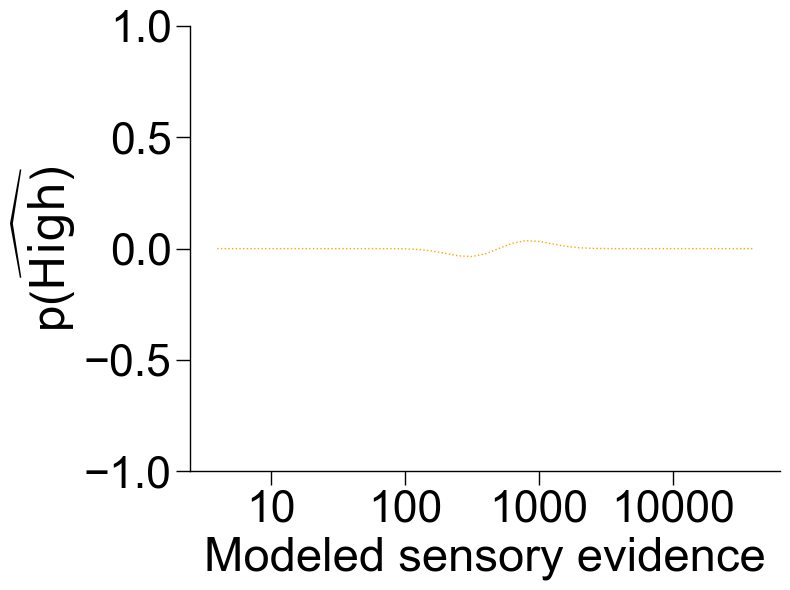

In [14]:
"""
What does the underlying posterior look like?
"""

def posteriorAgainstPercept(expt_Params):
    [_,_,mle_LikelihoodLatentTonegivenHigh,
    mle_LikelihoodLatentTonegivenLow] = posterior_array(freq_input=log_freq_percept,
                                                                        n_tones=3,p_back=expt_Params[4],
                                                                        log_prior=expt_Params[:3]) 
    
    
    mle_LikelihoodPerceptgivenHigh = np.zeros((len(log_freq_percept),
                                               len(log_freq_percept),len(log_freq_percept)))
    mle_LikelihoodPerceptgivenLow = np.zeros((len(log_freq_percept),
                                              len(log_freq_percept),len(log_freq_percept)))

    for itrue1 in range(len(log_freq_percept)):
        for itrue2 in range(len(log_freq_percept)):
            for itrue3 in range(len(log_freq_percept)):
                mle_probPerceptgivenLatentTones = Tones3dgrid([log_freq_percept[itrue1],
                                                               log_freq_percept[itrue2],
                                                               log_freq_percept[itrue3]],
                                                               sigma=expt_Params[3])
                mle_LikelihoodPerceptgivenHigh \
                += mle_probPerceptgivenLatentTones * mle_LikelihoodLatentTonegivenHigh[itrue1,itrue2,itrue3]
                mle_LikelihoodPerceptgivenLow \
                += mle_probPerceptgivenLatentTones * mle_LikelihoodLatentTonegivenLow[itrue1,itrue2,itrue3]
    mle_probHighgivenPercept = mle_LikelihoodPerceptgivenHigh*(1-expt_Params[5])/\
    (mle_LikelihoodPerceptgivenHigh*(1-expt_Params[5]) + mle_LikelihoodPerceptgivenLow*expt_Params[5])
    return mle_probHighgivenPercept

minMLE_probHighgivenPercept = posteriorAgainstPercept([2.55,2.85,0.1,0.17,0.99,0.5])

tone1_prob_behaviour = np.zeros((len(log_freq_percept)))
tone2_prob_behaviour = np.zeros((len(log_freq_percept)))
tone3_prob_behaviour = np.zeros((len(log_freq_percept)))

for i_tone in range(len(log_freq_percept)):
    tone1_prob_behaviour[i_tone] = np.mean(minMLE_probHighgivenPercept[i_tone,:,:])
    tone2_prob_behaviour[i_tone] = np.mean(minMLE_probHighgivenPercept[:,i_tone,:])
    tone3_prob_behaviour[i_tone] = np.mean(minMLE_probHighgivenPercept[:,:,i_tone])

posteriorProbabilities = (tone1_prob_behaviour+tone2_prob_behaviour+tone3_prob_behaviour)/3
posteriorProbabilities = posteriorProbabilities - posteriorProbabilities[0]
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.errorbar(log_freq_percept, posteriorProbabilities,
            yerr=np.std([tone1_prob_behaviour,tone2_prob_behaviour,tone3_prob_behaviour],axis=0)/np.sqrt(3),
            color='orange', ls='dotted',linewidth=1)
ax.set_xlabel('Modeled sensory evidence',fontsize=34)
ax.set_ylabel(r'p($\rm{\widehat{High}}$)',fontsize=34)
ax.set_xticks(ticks=np.arange(1,4.7,1))
ax.set_xticklabels(np.ceil(10**np.arange(1,4.7,1)).astype(int))
ax.set_yticks(ticks=[-1,-0.5,0,0.5,1])
ax.tick_params(axis='both',labelsize=32,length=10,width=1)
makeAxesPretty(ax)

plt.tight_layout()  
print("Norm of distractor weights compared to norm of all weights no context",
      (sum(np.abs(posteriorProbabilities[:17]))+
       sum(np.abs(posteriorProbabilities[-15:])))/sum(np.abs(posteriorProbabilities)))
#plt.savefig('figures/FromProlific/illustrations/experimenter=efc1_posteriorUsingPercepts.pdf',
#           bbox_inches='tight',transparent=True)


### Testing fits locally before sending it to cluster

In [ ]:
"""
Crude grid initially and then find minimum using scipy.optimize.fmin function.
"""
guess_low_mean = np.array([2.55]); guess_high_mean = np.array([2.85]);
guess_sigma = np.array([0.1]); guess_sensory_sigma = np.array([0.14]);
guess_p_back = np.array([0.9]); guess_p_low = np.array([0.52]);

# Constraining guesses of means of low and high distributions based on observed behaviour in figure shown above. 

neg_ll_array = np.zeros((len(guess_low_mean), len(guess_high_mean),
                         len(guess_sigma), len(guess_sensory_sigma), 
                         len(guess_p_back), len(guess_p_low)))
for lm in tqdm(range(len(guess_low_mean))):
    for hm in tqdm(range(len(guess_high_mean)), leave=False, desc="High mean"):
        for s in range(len(guess_sigma)):
            for ss in range(len(guess_sensory_sigma)):
                for pb in range(len(guess_p_back)):
                    for pl in range(len(guess_p_low)):
                        params = [guess_low_mean[lm], guess_high_mean[hm], guess_sigma[s], \
                                  guess_sensory_sigma[ss], guess_p_back[pb], guess_p_low[pl]]
                        neg_ll_array[lm,hm,s,ss,pb,pl],_ = MLE(params) 


In [ ]:
"""
Means and p_back corresponding to the least negative log likelihood value
"""
idxs = np.where(neg_ll_array == np.amin(neg_ll_array)) 
best_thetas = np.array([guess_low_mean[idxs[0]], guess_high_mean[idxs[1]], guess_sigma[idxs[2]], \
                        guess_sensory_sigma[idxs[3]], guess_p_back[idxs[4]], guess_p_low[idxs[5]]])
print(best_thetas, np.amin(neg_ll_array))


In [ ]:
# define mle function
def MLE_fmin(params):
    log_prior_low_mean, log_prior_high_mean, log_prior_sigma, sigma_sensory, prob_back, prob_low = \
    params[0], params[1], params[2], params[3], params[4], params[5] # inputs are guesses at our parameters  
    
    _,_,LikelihoodLatentTonegivenHigh,LikelihoodLatentTonegivenLow = \
    posterior_array(log_freq_seq_array, n_tones=len(trial_tones[0]), p_back=prob_back,
                    log_prior=[log_prior_low_mean,log_prior_high_mean,log_prior_sigma])

    LikelihoodPerceptgivenHigh = np.zeros((len(log_freq_percept),len(log_freq_percept),len(log_freq_percept)))
    LikelihoodPerceptgivenLow = np.zeros((len(log_freq_percept),len(log_freq_percept),len(log_freq_percept)))
    
    for itrue1 in range(len(log_freq_seq_array)):
        for itrue2 in range(len(log_freq_seq_array)):            
            for itrue3 in range(len(log_freq_seq_array)):
                probPerceptgivenLatentTones = Tones3dgrid([log_freq_seq_array[itrue1],
                                                           log_freq_seq_array[itrue2],
                                                           log_freq_seq_array[itrue3]],sigma=sigma_sensory)                                                           
                LikelihoodPerceptgivenHigh \
                += probPerceptgivenLatentTones * LikelihoodLatentTonegivenHigh[itrue1,itrue2,itrue3]
                LikelihoodPerceptgivenLow \
                += probPerceptgivenLatentTones * LikelihoodLatentTonegivenLow[itrue1,itrue2,itrue3]
    probHighgivenPercept = LikelihoodPerceptgivenHigh*(1-prob_low)/\
    (LikelihoodPerceptgivenHigh*(1-prob_low) + LikelihoodPerceptgivenLow*(prob_low))
        
    neg_ll = 0; 
    probability_high = np.zeros((len(trial_tones),1))
    for i_trial in range(len(trial_tones)):
        input_array_mat = Tones3dgrid(np.array([np.log10(trial_tones[i_trial][0]),
                                               np.log10(trial_tones[i_trial][1]),
                                               np.log10(trial_tones[i_trial][2])]),sigma=sigma_sensory)
        probability_high0 = np.sum(np.multiply(probHighgivenPercept>0.5,input_array_mat))
        probability_high[i_trial] = np.sum(np.multiply(probHighgivenPercept>0.5,input_array_mat))
            
        if trial_behaviour[i_trial]:
            if np.isnan(np.log(probability_high0 + 0.0000001)) \
            or np.isinf(np.log(probability_high0 + 0.0000001)) \
            or np.isnan(np.log(1-probability_high0 + 0.0000001)) \
            or np.isinf(np.log(1-probability_high0 + 0.0000001)):
                pdb.set_trace()
            neg_ll += -np.log(probability_high0 + 0.0000001) # if high dist is chosen by observer
        else:
            neg_ll += -np.log(1 - probability_high0 + 0.0000001) # if low dist is chosen by observer
    print(params, neg_ll)
    return(neg_ll)

"""
Optimization using neadler mead method and a simplex algorithm
"""
minimum_nll = scipy.optimize.fmin(MLE_fmin, [2.55,2.85,0.1,0.14,0.9,0.51], maxiter=10000, maxfun=10000, 
                                  xtol=0.01, ftol=0.01)

print(minimum_nll)
